# Headphone dataset review analysis #

Analyze how customers expressed their feelings about headphones bought through Amazon

Data from: https://www.kaggle.com/datasets/mdwaquarazam/headphone-dataset-review-analysis

---

### ***Imports*** ###

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from wordcloud import WordCloud, ImageColorGenerator

from spacy.lang.en.stop_words import STOP_WORDS
import string
from PIL import Image

import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('inputs/headphone_datn.csv')

In [4]:
df

,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS
0,Ramdika,Really Exceed my expectation.,Black,30-May-21,Okay.. I was skeptical at first to buy this as...,5
1,Sachin AK,Great for a change from inear buds,Black,01-Jun-21,The earphone is worth what you pay for. The de...,5
2,Manikandan Raj,For people with sensitive ears,Black,05-Sep-21,"Particularly for people with sensitive ears, w...",4
3,Reviewguy,I tested it for a week and here's a detailed r...,Iguana,11-Sep-21,Built Quality 6.5 10The lower wire is a durabl...,4
4,Sridhar Sarkar,Not a good headphone,Iguana,26-Jun-21,Don't go with the over all 4 start rating. Thi...,2
...,...,...,...,...,...,...
1599,Darshan,Simply fine,Blue,11-Jun-22,Quite good sound qualityAnd had impressively g...,4
1600,Happy Singh,Value for money,Spirit Lime,13-Jun-22,Osm,5
1601,sushanth,Value for money,White,09-Jun-22,"Earphones fits well onto the ears, doesn't blo...",5
1602,Mayuri shinde,Duplicate headphones... Not worth for price,White,09-Jun-22,Sound quality very bad... Over all very bad pr...,1


### ***Word cloud logo generation*** ###

In [5]:
class tiny_preprocessing(object):
    def __init__(self, text):
        self.text = text
    
    def __getitem__(self, index):
        return self.text[index]
    
    def lower(self):
        self.text = self.text.map(lambda x: str(x).lower())
        return self.text

    def remove_stop_words(self):
        self.text = self.text.map(lambda x: ' '.join([elem for elem in x.split() if elem not in STOP_WORDS]))
        return self.text
    
    def remove_punctuation(self):
        self.text = self.text.map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
        return self.text


In [6]:
data = tiny_preprocessing(df['COMMENTS'])

In [7]:
data.lower()
data.remove_stop_words()
data.remove_punctuation()

0       okay skeptical buy tight budget  honest little...
1       earphone worth pay for design earbud cause pai...
2       particularly people sensitive ears gets ear pa...
3       built quality 65 10the lower wire durable nylo...
4       dont 4 start rating boat brand endorse lot mon...
                              ...                        
1599         good sound qualityand impressively good bass
1600                                                  osm
1601    earphones fits ears doesnt block ear outside s...
1602              sound quality bad bad product happy buy
1603             callsmic goodbut comfort bad music worst
Name: COMMENTS, Length: 1604, dtype: object

In [8]:
data[:]

0       okay skeptical buy tight budget  honest little...
1       earphone worth pay for design earbud cause pai...
2       particularly people sensitive ears gets ear pa...
3       built quality 65 10the lower wire durable nylo...
4       dont 4 start rating boat brand endorse lot mon...
                              ...                        
1599         good sound qualityand impressively good bass
1600                                                  osm
1601    earphones fits ears doesnt block ear outside s...
1602              sound quality bad bad product happy buy
1603             callsmic goodbut comfort bad music worst
Name: COMMENTS, Length: 1604, dtype: object

In [9]:
text = ' '.join(data[:])

In [10]:
mask = np.array(Image.open('inputs/headphone-8215.jpg'))

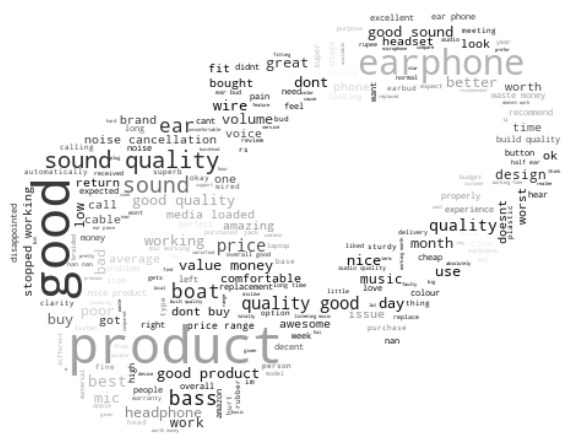

In [11]:
wc = WordCloud(background_color='white', max_words=500, mask = mask, max_font_size=60, random_state=0)
wc.generate(text)

image_colors = ImageColorGenerator(mask)
image_colors.default_color = [0,0,0]

plt.figure(figsize=[10,10])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off");
plt.savefig('outputs/headphone_word_cloud.png')

### ***Basic statistics for comments*** ###

Statistics done on raw text

Character count

In [12]:
df['char_counts'] = df['COMMENTS'].map(lambda x: len(str(x)))

Word count

In [13]:
df['word_counts'] = df['COMMENTS'].map(lambda x: len(str(x).split()))

Sentence count

In [14]:
df['sent_counts'] = df['COMMENTS'].map(lambda x: len(sent_tokenize(str(x))))

Average word length

In [15]:
df['avg_word_len'] = df["COMMENTS"].map(lambda x: np.mean([len(w) for w in str(x).split()]))

Average sent length

In [16]:
df['avg_sent_len'] = df['COMMENTS'].map(lambda x: np.mean([len(s.split()) for s in sent_tokenize(str(x))]))

In [17]:
df

,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS,char_counts,word_counts,sent_counts,avg_word_len,avg_sent_len
0,Ramdika,Really Exceed my expectation.,Black,30-May-21,Okay.. I was skeptical at first to buy this as...,5,333,65,3,4.138462,21.666667
1,Sachin AK,Great for a change from inear buds,Black,01-Jun-21,The earphone is worth what you pay for. The de...,5,374,67,5,4.597015,13.400000
2,Manikandan Raj,For people with sensitive ears,Black,05-Sep-21,"Particularly for people with sensitive ears, w...",4,211,41,2,4.170732,20.500000
3,Reviewguy,I tested it for a week and here's a detailed r...,Iguana,11-Sep-21,Built Quality 6.5 10The lower wire is a durabl...,4,1433,260,7,4.515385,37.142857
4,Sridhar Sarkar,Not a good headphone,Iguana,26-Jun-21,Don't go with the over all 4 start rating. Thi...,2,655,124,11,4.290323,11.272727
...,...,...,...,...,...,...,...,...,...,...,...
1599,Darshan,Simply fine,Blue,11-Jun-22,Quite good sound qualityAnd had impressively g...,4,54,8,1,5.875000,8.000000
1600,Happy Singh,Value for money,Spirit Lime,13-Jun-22,Osm,5,3,1,1,3.000000,1.000000
1601,sushanth,Value for money,White,09-Jun-22,"Earphones fits well onto the ears, doesn't blo...",5,198,36,3,4.527778,12.000000
1602,Mayuri shinde,Duplicate headphones... Not worth for price,White,09-Jun-22,Sound quality very bad... Over all very bad pr...,1,71,13,1,4.538462,13.000000


### ***Basic statistics for reviews*** ###

Statistics done on raw text

Character count

In [18]:
df['char_counts_rev'] = df['REVIEW_TITLE'].map(lambda x: len(str(x)))

Word count

In [19]:
df['word_counts_rev'] = df['REVIEW_TITLE'].map(lambda x: len(str(x).split()))

Sentence count

In [20]:
df['sent_counts_rev'] = df['REVIEW_TITLE'].map(lambda x: len(sent_tokenize(str(x))))

Average word length

In [21]:
df['avg_word_len_rev'] = df['REVIEW_TITLE'].map(lambda x: np.mean([len(w) for w in str(x).split()]))

Average sent length

In [22]:
df['avg_sent_len_rev'] = df['REVIEW_TITLE'].map(lambda x: np.mean([len(s.split()) for s in sent_tokenize(str(x))]))

### ***Text preprocessing*** ###

In [23]:
data[:]

0       okay skeptical buy tight budget  honest little...
1       earphone worth pay for design earbud cause pai...
2       particularly people sensitive ears gets ear pa...
3       built quality 65 10the lower wire durable nylo...
4       dont 4 start rating boat brand endorse lot mon...
                              ...                        
1599         good sound qualityand impressively good bass
1600                                                  osm
1601    earphones fits ears doesnt block ear outside s...
1602              sound quality bad bad product happy buy
1603             callsmic goodbut comfort bad music worst
Name: COMMENTS, Length: 1604, dtype: object

In [24]:
data_rev = tiny_preprocessing(df['REVIEW_TITLE'])

In [25]:
data_rev.lower()
data_rev.remove_stop_words()
data_rev.remove_punctuation()

0                      exceed expectation
1                 great change inear buds
2                   people sensitive ears
3       tested week heres detailed review
4                          good headphone
                      ...                
1599                          simply fine
1600                          value money
1601                          value money
1602     duplicate headphones worth price
1603                      worstonly calls
Name: REVIEW_TITLE, Length: 1604, dtype: object

In [26]:
df['comments_prep'] = data[:]
df['review_prep'] = data_rev[:]

### ***Basic statistics for customers*** ###

Anonymous customer

In [27]:
df['Customer_Name'].value_counts()

Amazon Customer      86
Rahul                 5
Abhishek              4
Yogesh                3
Ajay                  3
                     ..
Javed                 1
As C.                 1
Kishorbhai Kotiya     1
Ankita yadav          1
SIDDHARTH             1
Name: Customer_Name, Length: 1465, dtype: int64

In [28]:
df['anonymous_customer'] = df['Customer_Name'].map(lambda x: True if x != 'Amazon Customer' else False)

In [29]:
df

,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS,char_counts,word_counts,sent_counts,avg_word_len,avg_sent_len,char_counts_rev,word_counts_rev,sent_counts_rev,avg_word_len_rev,avg_sent_len_rev,comments_prep,review_prep,anonymous_customer
0,Ramdika,Really Exceed my expectation.,Black,30-May-21,Okay.. I was skeptical at first to buy this as...,5,333,65,3,4.138462,21.666667,29,4,1,6.500000,4.0,okay skeptical buy tight budget honest little...,exceed expectation,True
1,Sachin AK,Great for a change from inear buds,Black,01-Jun-21,The earphone is worth what you pay for. The de...,5,374,67,5,4.597015,13.400000,34,7,1,4.000000,7.0,earphone worth pay for design earbud cause pai...,great change inear buds,True
2,Manikandan Raj,For people with sensitive ears,Black,05-Sep-21,"Particularly for people with sensitive ears, w...",4,211,41,2,4.170732,20.500000,30,5,1,5.200000,5.0,particularly people sensitive ears gets ear pa...,people sensitive ears,True
3,Reviewguy,I tested it for a week and here's a detailed r...,Iguana,11-Sep-21,Built Quality 6.5 10The lower wire is a durabl...,4,1433,260,7,4.515385,37.142857,51,11,1,3.727273,11.0,built quality 65 10the lower wire durable nylo...,tested week heres detailed review,True
4,Sridhar Sarkar,Not a good headphone,Iguana,26-Jun-21,Don't go with the over all 4 start rating. Thi...,2,655,124,11,4.290323,11.272727,20,4,1,4.250000,4.0,dont 4 start rating boat brand endorse lot mon...,good headphone,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,Darshan,Simply fine,Blue,11-Jun-22,Quite good sound qualityAnd had impressively g...,4,54,8,1,5.875000,8.000000,11,2,1,5.000000,2.0,good sound qualityand impressively good bass,simply fine,True
1600,Happy Singh,Value for money,Spirit Lime,13-Jun-22,Osm,5,3,1,1,3.000000,1.000000,15,3,1,4.333333,3.0,osm,value money,True
1601,sushanth,Value for money,White,09-Jun-22,"Earphones fits well onto the ears, doesn't blo...",5,198,36,3,4.527778,12.000000,15,3,1,4.333333,3.0,earphones fits ears doesnt block ear outside s...,value money,True
1602,Mayuri shinde,Duplicate headphones... Not worth for price,White,09-Jun-22,Sound quality very bad... Over all very bad pr...,1,71,13,1,4.538462,13.000000,43,6,1,6.333333,6.0,sound quality bad bad product happy buy,duplicate headphones worth price,True


### ***Histograms*** ###

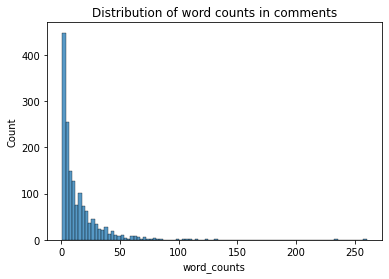

In [30]:
plt.title('Distribution of word counts in comments')
sns.histplot(data = df['word_counts']);

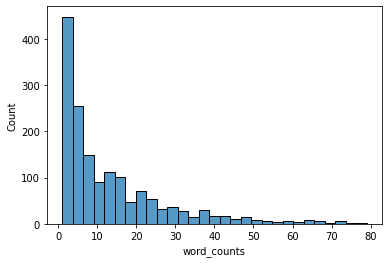

In [31]:
sns.histplot(df[df['word_counts'] < np.percentile(df['word_counts'], 99)]['word_counts']);

In [32]:
np.median(df['word_counts'])

8.0

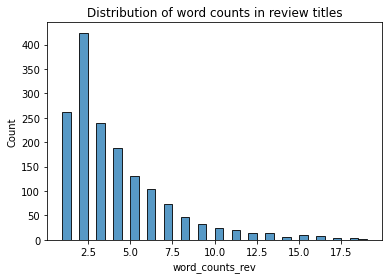

In [33]:
plt.title('Distribution of word counts in review titles')
sns.histplot(data = df['word_counts_rev']);

In [34]:
df['word_counts_rev'].max()

19

c:\Users\mariu\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


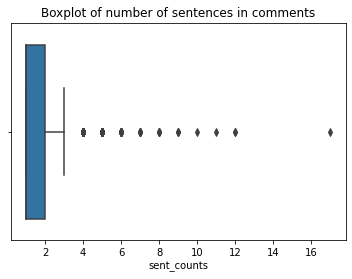

In [35]:
plt.title('Boxplot of number of sentences in comments')
sns.boxplot(df['sent_counts']);

In [36]:
df['sent_counts'].describe()

count    1604.000000
mean        1.593516
std         1.336883
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: sent_counts, dtype: float64

---

🔵`Conclusion 1`🔵

Most of the comments aren't longer then 80 words. The median of the length of comments in 8 words. The are usually 1 or 2 sentences in a comment. The review titles are mostly short - usually 2, with maximal value of 19 words.

---

### ***General Term Frequency Analysis*** ###

Tokenize comments

In [37]:
comments_prep_tokens = df['comments_prep'].str.split()

Build corpus

In [38]:
corpus = []
for token in comments_prep_tokens:
    corpus += token

Show most common words

In [39]:
most_common_words = nltk.FreqDist(corpus).most_common(10)
most_common_words

[('good', 673),
 ('quality', 543),
 ('sound', 467),
 ('product', 414),
 ('bass', 166),
 ('ear', 151),
 ('working', 151),
 ('boat', 149),
 ('price', 145),
 ('earphones', 140)]

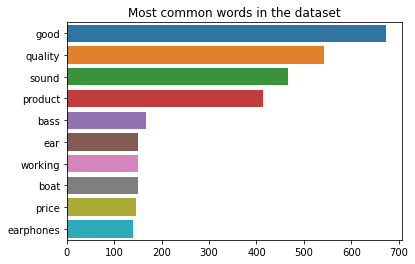

In [40]:
plt.title('Most common words in the dataset')
sns.barplot(x = [elem[1] for elem in most_common_words], y = [elem[0] for elem in most_common_words]);

In [41]:
print(f'Word count of the word "very": {nltk.FreqDist(corpus)["very"]}')
print(f'Word count of the word "not": {nltk.FreqDist(corpus)["not"]}')

Word count of the word "very": 1
Word count of the word "not": 2


### ***Sentiment based term Frequency Analysis*** ###

Sentiment construction based an ratings

In [42]:
sentiment_dict = {'positive': [5, 4], 'neutral': [3], 'negative': [1, 2]}

def key_return(x):
    return next(k for k,v in sentiment_dict.items() if x in v)

df['RATINGS_SENTIMENT'] = df['RATINGS'].map(lambda x: key_return(x))

In [43]:
df['RATINGS_SENTIMENT'].value_counts()

positive    933
negative    520
neutral     151
Name: RATINGS_SENTIMENT, dtype: int64

Positive comments

In [44]:
positive_tokens = df[df['RATINGS_SENTIMENT'] == 'positive']['comments_prep'].str.split()
positive_corpus = []
for token in positive_tokens:
    positive_corpus += token

In [45]:
most_common_words_positive = nltk.FreqDist(positive_corpus).most_common(10)

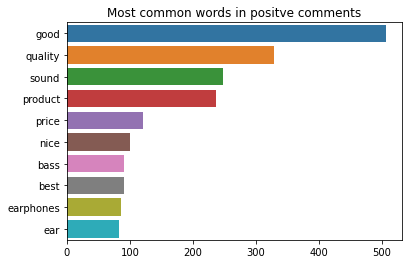

In [46]:
plt.title('Most common words in positve comments')
sns.barplot(x = [elem[1] for elem in most_common_words_positive], y = [elem[0] for elem in most_common_words_positive]);

Negative comments

In [47]:
negative_tokens = df[df['RATINGS_SENTIMENT'] == 'negative']['comments_prep'].str.split()
negative_corpus = []
for token in negative_tokens:
    negative_corpus += token

In [49]:
most_common_words_negative = nltk.FreqDist(negative_corpus).most_common(10)

In [50]:
most_common_words_negative

[('sound', 162),
 ('quality', 160),
 ('product', 153),
 ('working', 117),
 ('good', 89),
 ('boat', 73),
 ('buy', 65),
 ('dont', 60),
 ('ear', 53),
 ('poor', 52)]

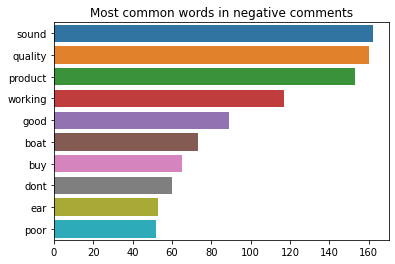

In [51]:
plt.title('Most common words in negative comments')
sns.barplot(x = [elem[1] for elem in most_common_words_negative], y = [elem[0] for elem in most_common_words_negative]);

---

🔵`Conclusion 1`🔵

Top single tokens for positive and negative reviews are in most cases the same and don't provide any meaningful insight.

---

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

In [57]:
vec = CountVectorizer(ngram_range=(2,2))
vec.fit_transform(df['comments_prep']).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [67]:
n_grams = list(nltk.ngrams(corpus, 2))
nltk.FreqDist(n_grams)

FreqDist({('sound', 'quality'): 218, ('quality', 'good'): 109, ('good', 'product'): 77, ('value', 'money'): 68, ('good', 'quality'): 68, ('good', 'sound'): 66, ('product', 'good'): 44, ('noise', 'cancellation'): 44, ('stopped', 'working'): 39, ('dont', 'buy'): 39, ...})